# AUTOENCODER

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Basic Autoencoder

In [2]:
# Basic Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=64):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Output between 0 and 1 for image reconstruction
        )
    
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Get encoded representation"""
        return self.encoder(x)
    
    def decode(self, x):
        """Decode from encoded representation"""
        return self.decoder(x)

# Convolutional Autoencoder

In [3]:
class ConvAutoencoder(nn.Module):
    """Convolutional Autoencoder for better image reconstruction"""
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # 7x7 -> 1x1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train Autoencoder

In [14]:
def train_autoencoder(model, train_loader, num_epochs=10, learning_rate=1e-3, device:str="cpu"):
    """Train the autoencoder"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Flatten data for fully connected autoencoder
            if isinstance(model, Autoencoder):
                data = data.view(data.size(0), -1)
            
            # Forward pass
            data = data.to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            data = data.to('cpu')
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

# Visualize Reconstruction

In [5]:
def visualize_reconstruction(model, test_loader, num_images=8):
    """Visualize original vs reconstructed images"""
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data, _ = next(iter(test_loader))
        
        # Prepare data based on model type
        if isinstance(model, Autoencoder):
            data_input = data.view(data.size(0), -1)
            reconstructed = model(data_input)
            reconstructed = reconstructed.view(-1, 1, 28, 28)
        else:
            reconstructed = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Run

Using mps device
Training Fully Connected Autoencoder...
Epoch [1/5], Loss: 0.0542
Epoch [2/5], Loss: 0.0253
Epoch [3/5], Loss: 0.0197
Epoch [4/5], Loss: 0.0165
Epoch [5/5], Loss: 0.0144

Training Convolutional Autoencoder...
Epoch [1/5], Loss: 0.0524
Epoch [2/5], Loss: 0.0104
Epoch [3/5], Loss: 0.0064
Epoch [4/5], Loss: 0.0049
Epoch [5/5], Loss: 0.0041

Visualizing reconstructions...


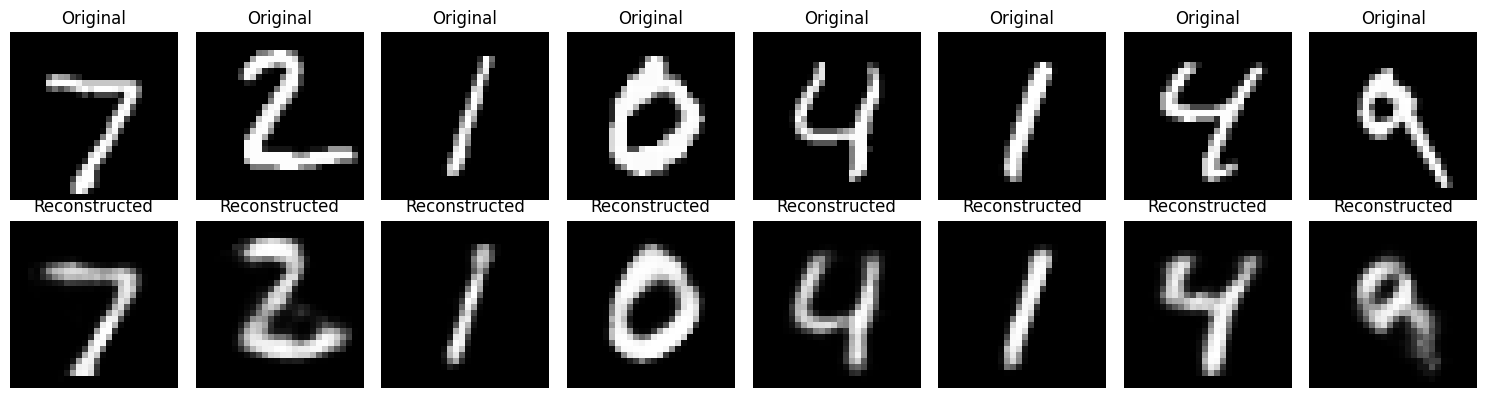

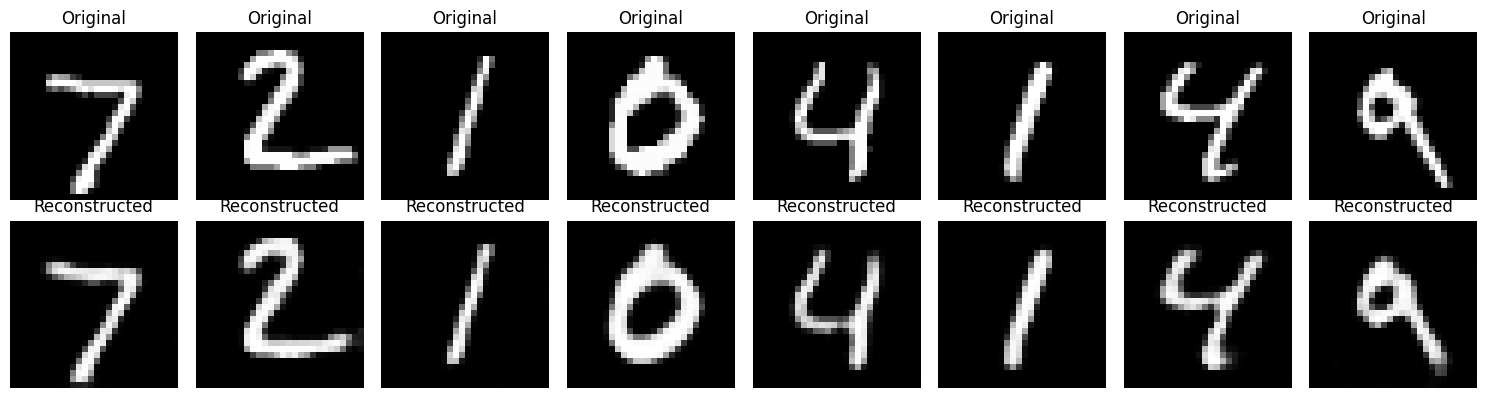

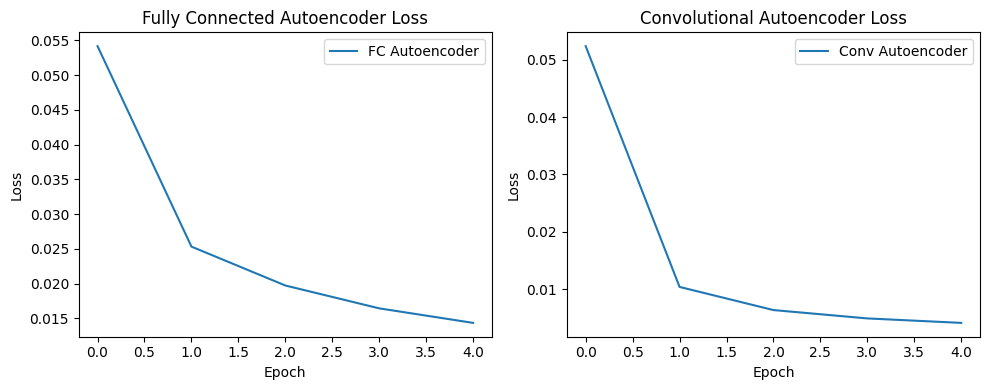


Testing encoder for dimensionality reduction...
Original data shape: torch.Size([128, 784])
Encoded data shape: torch.Size([128, 64])
Compression ratio: 12.2x


In [19]:
# Example usage
# Set device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Training Fully Connected Autoencoder...")
# Create and train fully connected autoencoder
fc_autoencoder = Autoencoder(input_dim=784, encoding_dim=64).to(device)
fc_losses = train_autoencoder(fc_autoencoder, train_loader, num_epochs=5, device=device)
fc_autoencoder = fc_autoencoder.to('cpu')

print("\nTraining Convolutional Autoencoder...")
# Create and train convolutional autoencoder
conv_autoencoder = ConvAutoencoder().to(device)
conv_losses = train_autoencoder(conv_autoencoder, train_loader, num_epochs=5, device=device)
conv_autoencoder = conv_autoencoder.to('cpu')

# Visualize results
print("\nVisualizing reconstructions...")
visualize_reconstruction(fc_autoencoder, test_loader)
visualize_reconstruction(conv_autoencoder, test_loader)

# Plot training losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fc_losses, label='FC Autoencoder')
plt.title('Fully Connected Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(conv_losses, label='Conv Autoencoder')
plt.title('Convolutional Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Example of using the encoder for dimensionality reduction
print("\nTesting encoder for dimensionality reduction...")
fc_autoencoder.eval()
with torch.no_grad():
    sample_data, _ = next(iter(test_loader))
    sample_data_flat = sample_data.view(sample_data.size(0), -1)
    
    # Original dimension: 784 (28x28)
    print(f"Original data shape: {sample_data_flat.shape}")
    
    # Encoded dimension: 64
    encoded_data = fc_autoencoder.encode(sample_data_flat)
    print(f"Encoded data shape: {encoded_data.shape}")
    
    # Compression ratio
    compression_ratio = 784 / 64
    print(f"Compression ratio: {compression_ratio:.1f}x")

# SVD

How does SVD do compared with an autoencoder?


EVALUATING PCA ON WINE DATASET
Dataset shape: (178, 13)
Number of classes: 3
Using 10 components
PCA DIMENSIONALITY REDUCTION QUALITY REPORT
Original dimensions: 13
Reduced dimensions: 10
Dimensionality reduction ratio: 0.769

VARIANCE EXPLAINED:
--------------------
Total variance explained: 0.962

Components needed for variance thresholds:
  80%: 5 components
  90%: 8 components
  95%: 10 components
  99%: 10 components

RECONSTRUCTION QUALITY:
-------------------------
Mean Squared Error: 0.038303
Root Mean Squared Error: 0.195711
Mean Absolute Error: 0.137418
Relative Error: 0.038303

DISTANCE PRESERVATION:
----------------------
Spearman correlation: 0.998
P-value: 0.00e+00
✓ Excellent distance preservation

NEIGHBORHOOD PRESERVATION:
---------------------------
Mean preservation (k=10): 0.901
✓ Excellent neighborhood preservation

CLASSIFICATION PERFORMANCE:
----------------------------
RandomForest:
  Original data accuracy: 1.000
  Reduced data accuracy: 0.907
  Accuracy reten

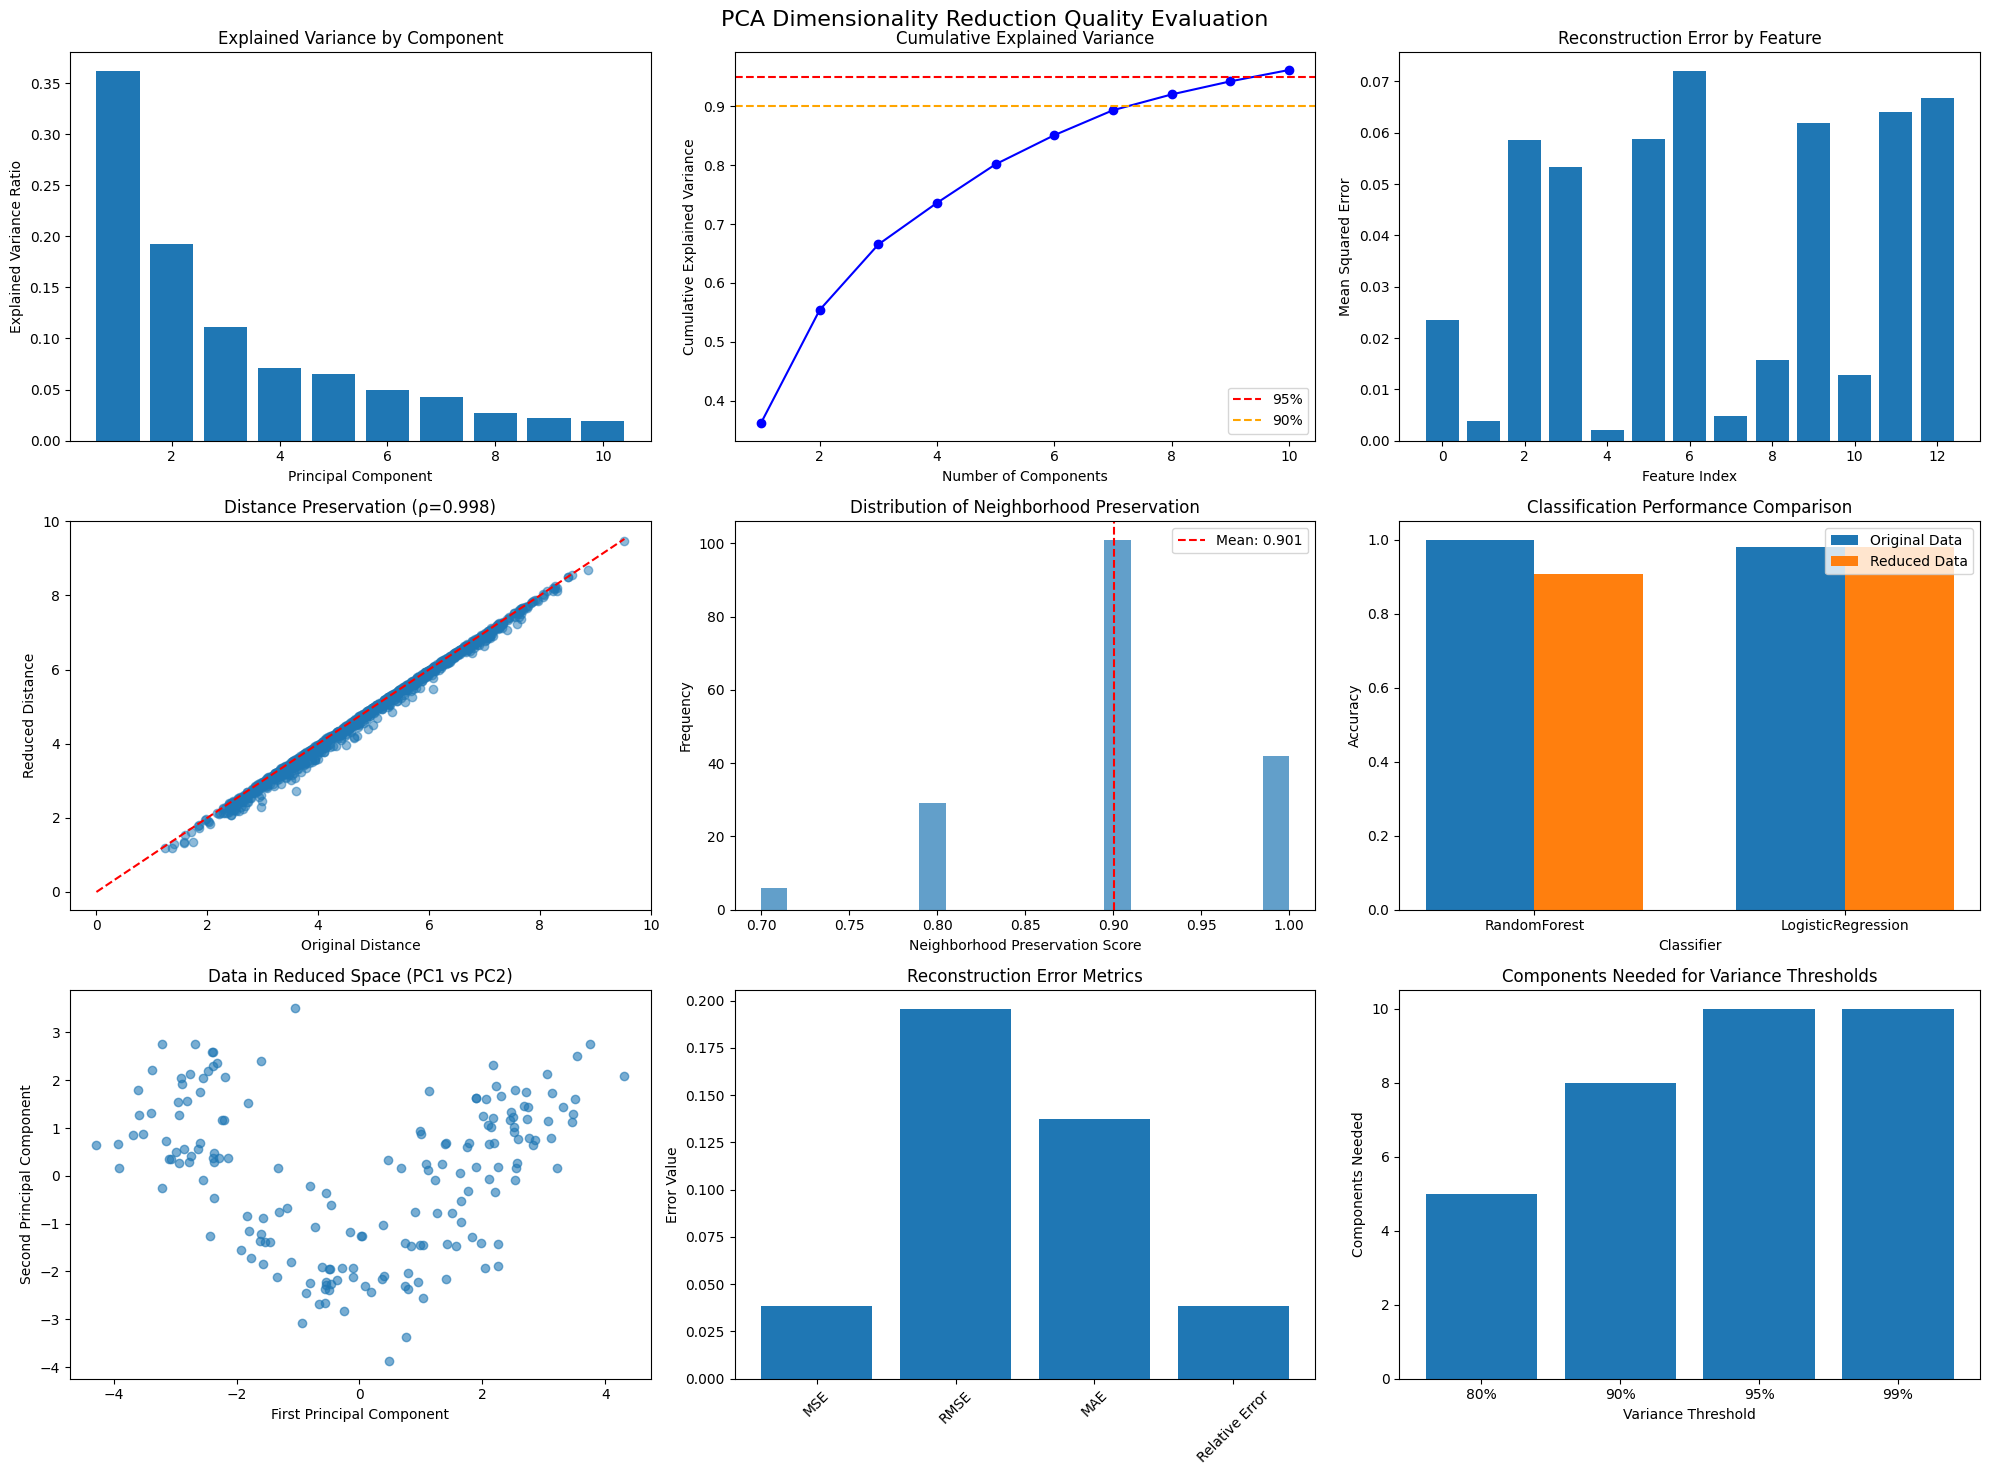


EVALUATING PCA ON BREAST CANCER DATASET
Dataset shape: (569, 30)
Number of classes: 2
Using 10 components
PCA DIMENSIONALITY REDUCTION QUALITY REPORT
Original dimensions: 30
Reduced dimensions: 10
Dimensionality reduction ratio: 0.333

VARIANCE EXPLAINED:
--------------------
Total variance explained: 0.952

Components needed for variance thresholds:
  80%: 5 components
  90%: 7 components
  95%: 10 components
  99%: 10 components

RECONSTRUCTION QUALITY:
-------------------------
Mean Squared Error: 0.048431
Root Mean Squared Error: 0.220071
Mean Absolute Error: 0.150032
Relative Error: 0.048431

DISTANCE PRESERVATION:
----------------------
Spearman correlation: 0.999
P-value: 0.00e+00
✓ Excellent distance preservation

NEIGHBORHOOD PRESERVATION:
---------------------------
Mean preservation (k=10): 0.859
✓ Excellent neighborhood preservation

CLASSIFICATION PERFORMANCE:
----------------------------
RandomForest:
  Original data accuracy: 0.936
  Reduced data accuracy: 0.936
  Accur

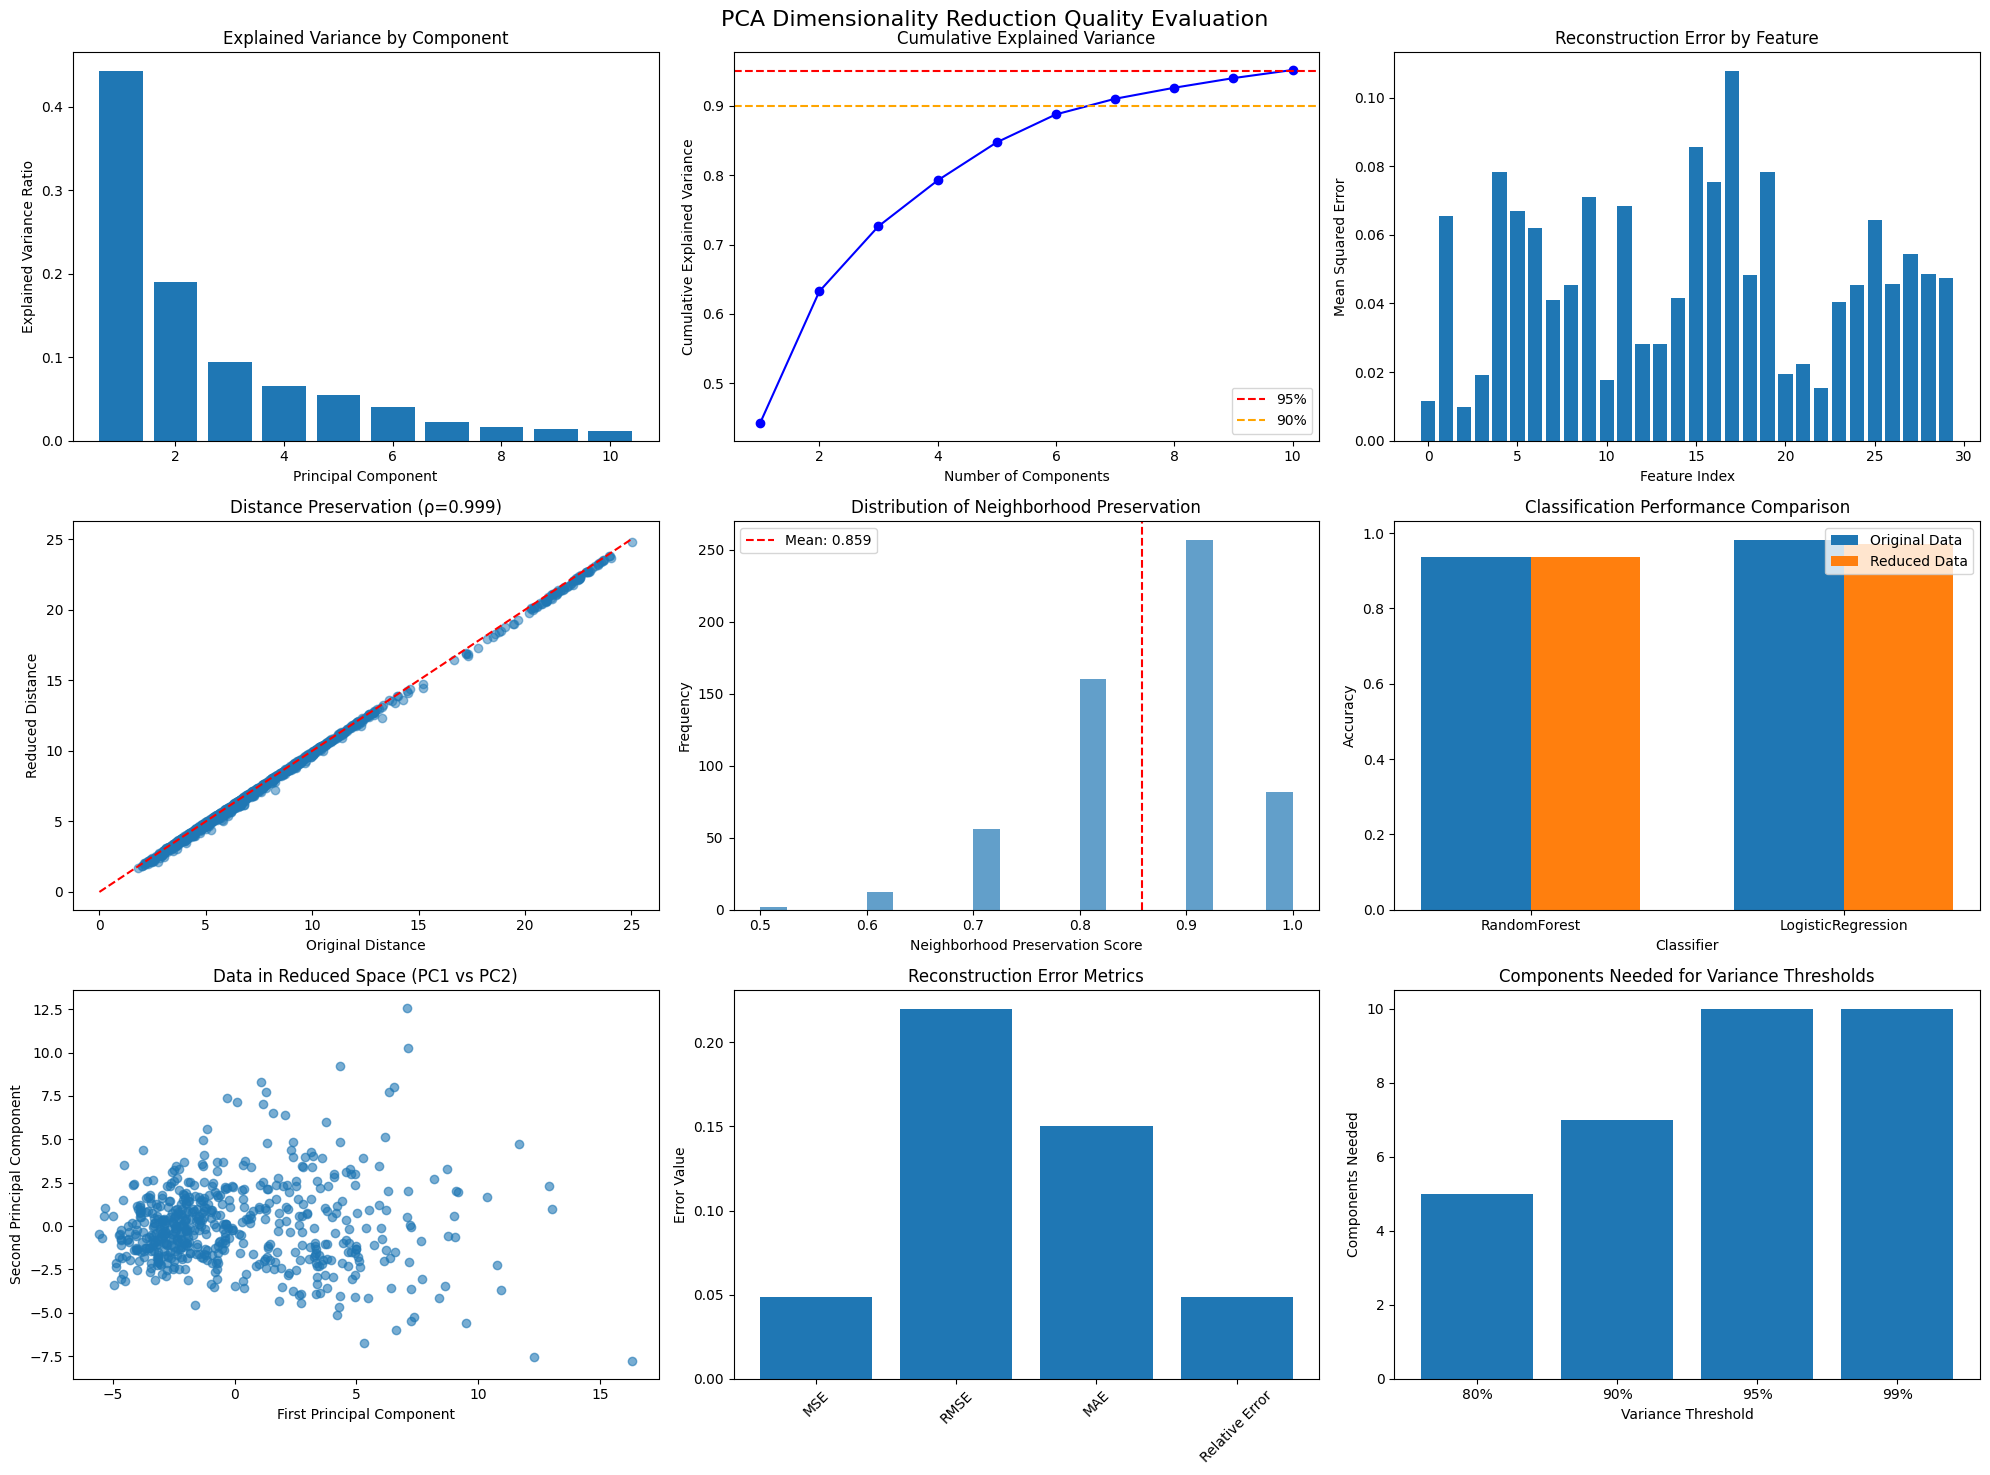


EVALUATING PCA ON DIGITS DATASET
Dataset shape: (1797, 64)
Number of classes: 10
Using 10 components
PCA DIMENSIONALITY REDUCTION QUALITY REPORT
Original dimensions: 64
Reduced dimensions: 10
Dimensionality reduction ratio: 0.156

VARIANCE EXPLAINED:
--------------------
Total variance explained: 0.589

Components needed for variance thresholds:
  80%: 10 components
  90%: 10 components
  95%: 10 components
  99%: 10 components

RECONSTRUCTION QUALITY:
-------------------------
Mean Squared Error: 0.391985
Root Mean Squared Error: 0.626087
Mean Absolute Error: 0.403038
Relative Error: 0.411262

DISTANCE PRESERVATION:
----------------------
Spearman correlation: 0.932
P-value: 0.00e+00
✓ Excellent distance preservation

NEIGHBORHOOD PRESERVATION:
---------------------------
Mean preservation (k=10): 0.580
⚠ Moderate neighborhood preservation

CLASSIFICATION PERFORMANCE:
----------------------------
RandomForest:
  Original data accuracy: 0.969
  Reduced data accuracy: 0.917
  Accuracy 

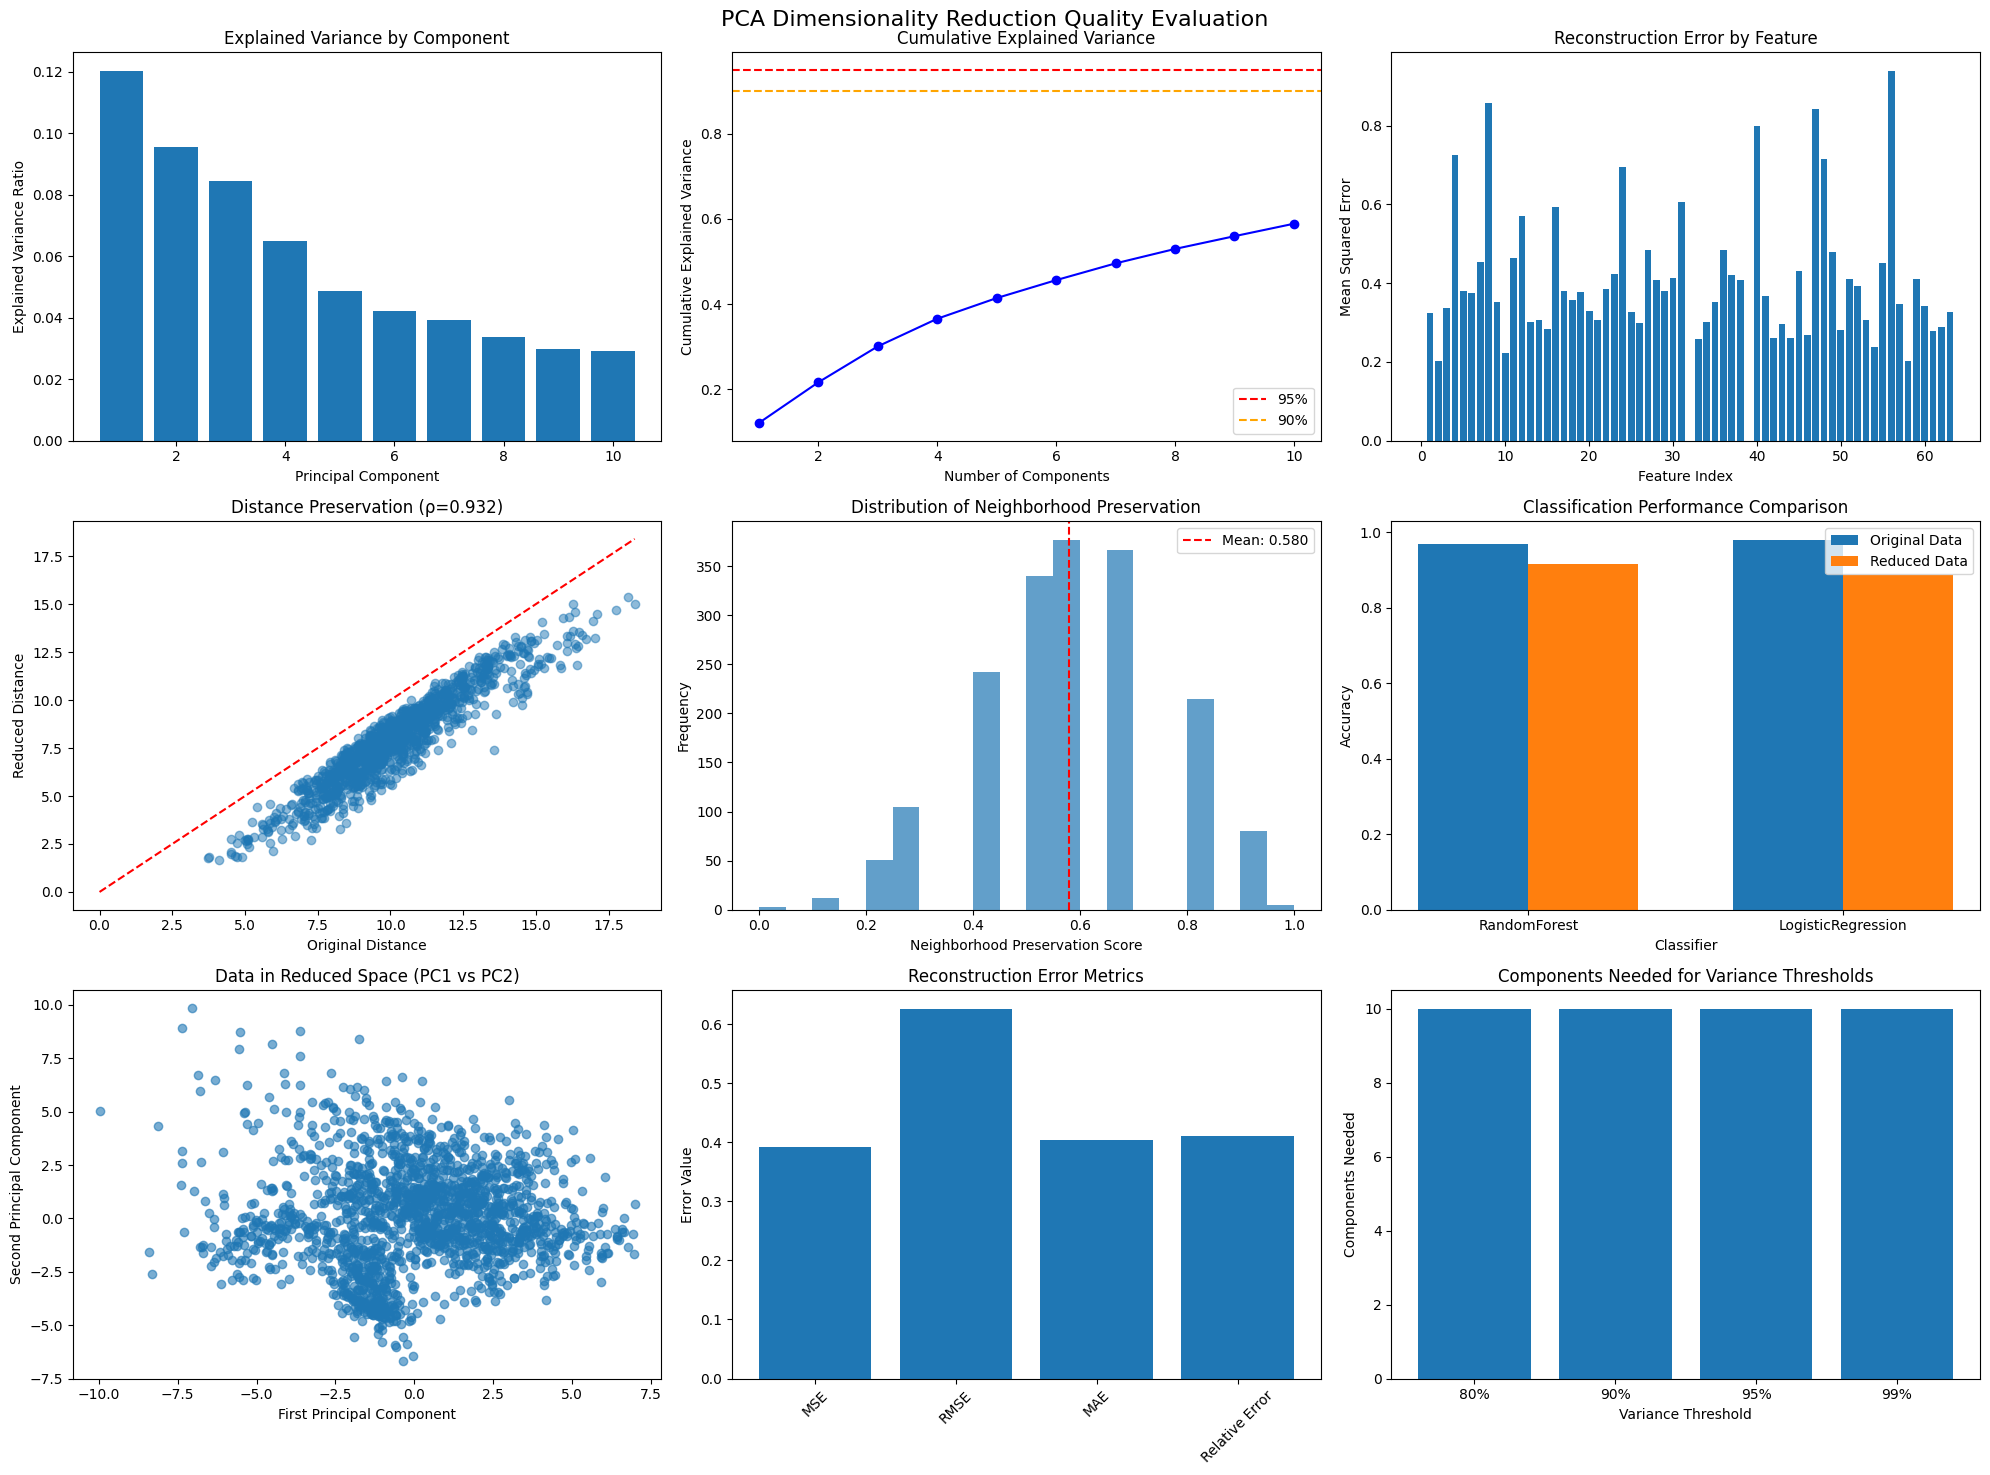


PCA EVALUATION COMPLETE
The PCAQualityEvaluator class provides:
1. Variance explained analysis
2. Reconstruction error metrics
3. Distance preservation evaluation
4. Neighborhood preservation assessment
5. Classification performance comparison
6. Comprehensive visualization
7. Detailed text reports


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_digits, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

class PCAQualityEvaluator:
    """
    A comprehensive class for evaluating PCA dimensionality reduction quality
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.pca = None
        self.X_original = None
        self.X_scaled = None
        self.X_reduced = None
        self.X_reconstructed = None
        self.results = {}
    
    def fit_transform(self, X, n_components=None):
        """
        Fit PCA and transform the data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Input data
        n_components : int or None
            Number of components to keep
        """
        self.X_original = X.copy()
        
        # Standardize the data
        self.X_scaled = self.scaler.fit_transform(X)
        
        # Fit PCA
        if n_components is None:
            n_components = min(X.shape[0], X.shape[1])
        
        self.pca = PCA(n_components=n_components, random_state=self.random_state)
        self.X_reduced = self.pca.fit_transform(self.X_scaled)
        
        # Reconstruct data for quality evaluation
        self.X_reconstructed = self.pca.inverse_transform(self.X_reduced)
        
        return self.X_reduced
    
    def evaluate_variance_explained(self):
        """Evaluate variance explained by components"""
        if self.pca is None:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        explained_var = self.pca.explained_variance_ratio_
        cumulative_var = np.cumsum(explained_var)
        
        self.results['explained_variance'] = explained_var
        self.results['cumulative_variance'] = cumulative_var
        
        # Find number of components for different variance thresholds
        thresholds = [0.80, 0.90, 0.95, 0.99]
        components_needed = {}
        for threshold in thresholds:
            idx = np.argmax(cumulative_var >= threshold)
            components_needed[threshold] = idx + 1 if cumulative_var[idx] >= threshold else len(cumulative_var)
        
        self.results['components_for_variance'] = components_needed
        
        return explained_var, cumulative_var, components_needed
    
    def evaluate_reconstruction_error(self):
        """Evaluate reconstruction error metrics"""
        if self.X_reconstructed is None:
            raise ValueError("Data not transformed. Call fit_transform first.")
        
        # Mean Squared Error
        mse = np.mean((self.X_scaled - self.X_reconstructed) ** 2)
        
        # Root Mean Squared Error
        rmse = np.sqrt(mse)
        
        # Mean Absolute Error
        mae = np.mean(np.abs(self.X_scaled - self.X_reconstructed))
        
        # Relative reconstruction error
        relative_error = mse / np.var(self.X_scaled)
        
        # Per-feature reconstruction error
        feature_mse = np.mean((self.X_scaled - self.X_reconstructed) ** 2, axis=0)
        
        self.results['reconstruction_errors'] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'relative_error': relative_error,
            'feature_mse': feature_mse
        }
        
        return mse, rmse, mae, relative_error
    
    def evaluate_distance_preservation(self, n_samples=500):
        """Evaluate how well pairwise distances are preserved"""
        if self.X_reduced is None:
            raise ValueError("Data not transformed. Call fit_transform first.")
        
        # Sample subset for computational efficiency
        n_samples = min(n_samples, self.X_scaled.shape[0])
        indices = np.random.choice(self.X_scaled.shape[0], n_samples, replace=False)
        
        X_sample_original = self.X_scaled[indices]
        X_sample_reduced = self.X_reduced[indices]
        
        # Compute pairwise distances
        distances_original = euclidean_distances(X_sample_original)
        distances_reduced = euclidean_distances(X_sample_reduced)
        
        # Flatten distance matrices (excluding diagonal)
        mask = np.triu(np.ones_like(distances_original, dtype=bool), k=1)
        dist_orig_flat = distances_original[mask]
        dist_reduced_flat = distances_reduced[mask]
        
        # Compute correlation between original and reduced distances
        distance_correlation, p_value = spearmanr(dist_orig_flat, dist_reduced_flat)
        
        self.results['distance_preservation'] = {
            'correlation': distance_correlation,
            'p_value': p_value
        }
        
        return distance_correlation, p_value
    
    def evaluate_neighborhood_preservation(self, k=10):
        """Evaluate how well k-nearest neighborhoods are preserved"""
        if self.X_reduced is None:
            raise ValueError("Data not transformed. Call fit_transform first.")
        
        # Find k-nearest neighbors in original space
        nbrs_original = NearestNeighbors(n_neighbors=k+1).fit(self.X_scaled)
        _, neighbors_original = nbrs_original.kneighbors(self.X_scaled)
        
        # Find k-nearest neighbors in reduced space
        nbrs_reduced = NearestNeighbors(n_neighbors=k+1).fit(self.X_reduced)
        _, neighbors_reduced = nbrs_reduced.kneighbors(self.X_reduced)
        
        # Compute neighborhood preservation (excluding self)
        preservation_scores = []
        for i in range(len(neighbors_original)):
            orig_neighbors = set(neighbors_original[i][1:])  # Exclude self
            reduced_neighbors = set(neighbors_reduced[i][1:])  # Exclude self
            
            intersection = len(orig_neighbors.intersection(reduced_neighbors))
            preservation_score = intersection / k
            preservation_scores.append(preservation_score)
        
        mean_preservation = np.mean(preservation_scores)
        
        self.results['neighborhood_preservation'] = {
            'mean_preservation': mean_preservation,
            'preservation_scores': preservation_scores,
            'k': k
        }
        
        return mean_preservation, preservation_scores
    
    def evaluate_classification_performance(self, y, test_size=0.3):
        """Evaluate classification performance on reduced vs original data"""
        if self.X_reduced is None:
            raise ValueError("Data not transformed. Call fit_transform first.")
        
        # Split data
        X_train_orig, X_test_orig, X_train_red, X_test_red, y_train, y_test = train_test_split(
            self.X_scaled, self.X_reduced, y, test_size=test_size, 
            random_state=self.random_state, stratify=y
        )
        
        # Train classifiers
        classifiers = {
            'RandomForest': RandomForestClassifier(random_state=self.random_state),
            'LogisticRegression': LogisticRegression(random_state=self.random_state, max_iter=1000)
        }
        
        results = {}
        for name, clf in classifiers.items():
            # Original data
            clf_orig = clf.__class__(**clf.get_params())
            clf_orig.fit(X_train_orig, y_train)
            y_pred_orig = clf_orig.predict(X_test_orig)
            acc_orig = accuracy_score(y_test, y_pred_orig)
            
            # Reduced data
            clf_red = clf.__class__(**clf.get_params())
            clf_red.fit(X_train_red, y_train)
            y_pred_red = clf_red.predict(X_test_red)
            acc_red = accuracy_score(y_test, y_pred_red)
            
            results[name] = {
                'original_accuracy': acc_orig,
                'reduced_accuracy': acc_red,
                'accuracy_ratio': acc_red / acc_orig
            }
        
        self.results['classification_performance'] = results
        return results
    
    def plot_evaluation_results(self, figsize=(20, 15)):
        """Create comprehensive visualization of evaluation results"""
        if not self.results:
            raise ValueError("No evaluation results found. Run evaluation methods first.")
        
        fig, axes = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('PCA Dimensionality Reduction Quality Evaluation', fontsize=16)
        
        # 1. Explained Variance
        if 'explained_variance' in self.results:
            ax = axes[0, 0]
            n_components = len(self.results['explained_variance'])
            ax.bar(range(1, n_components + 1), self.results['explained_variance'])
            ax.set_xlabel('Principal Component')
            ax.set_ylabel('Explained Variance Ratio')
            ax.set_title('Explained Variance by Component')
            
        # 2. Cumulative Variance
        if 'cumulative_variance' in self.results:
            ax = axes[0, 1]
            cumvar = self.results['cumulative_variance']
            ax.plot(range(1, len(cumvar) + 1), cumvar, 'bo-')
            ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
            ax.axhline(y=0.90, color='orange', linestyle='--', label='90%')
            ax.set_xlabel('Number of Components')
            ax.set_ylabel('Cumulative Explained Variance')
            ax.set_title('Cumulative Explained Variance')
            ax.legend()
            
        # 3. Reconstruction Error by Feature
        if 'reconstruction_errors' in self.results:
            ax = axes[0, 2]
            feature_errors = self.results['reconstruction_errors']['feature_mse']
            ax.bar(range(len(feature_errors)), feature_errors)
            ax.set_xlabel('Feature Index')
            ax.set_ylabel('Mean Squared Error')
            ax.set_title('Reconstruction Error by Feature')
            
        # 4. Distance Preservation Scatter
        if 'distance_preservation' in self.results:
            ax = axes[1, 0]
            # Create a sample scatter plot for visualization
            n_sample = min(200, self.X_scaled.shape[0])
            indices = np.random.choice(self.X_scaled.shape[0], n_sample, replace=False)
            X_sample_orig = self.X_scaled[indices]
            X_sample_red = self.X_reduced[indices]
            
            dist_orig = euclidean_distances(X_sample_orig[:50])
            dist_red = euclidean_distances(X_sample_red[:50])
            
            mask = np.triu(np.ones_like(dist_orig, dtype=bool), k=1)
            ax.scatter(dist_orig[mask], dist_red[mask], alpha=0.5)
            ax.plot([dist_orig.min(), dist_orig.max()], [dist_orig.min(), dist_orig.max()], 'r--')
            ax.set_xlabel('Original Distance')
            ax.set_ylabel('Reduced Distance')
            ax.set_title(f'Distance Preservation (ρ={self.results["distance_preservation"]["correlation"]:.3f})')
            
        # 5. Neighborhood Preservation Distribution
        if 'neighborhood_preservation' in self.results:
            ax = axes[1, 1]
            preservation_scores = self.results['neighborhood_preservation']['preservation_scores']
            ax.hist(preservation_scores, bins=20, alpha=0.7)
            ax.axvline(np.mean(preservation_scores), color='r', linestyle='--', 
                      label=f'Mean: {np.mean(preservation_scores):.3f}')
            ax.set_xlabel('Neighborhood Preservation Score')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution of Neighborhood Preservation')
            ax.legend()
            
        # 6. Classification Performance Comparison
        if 'classification_performance' in self.results:
            ax = axes[1, 2]
            classifiers = list(self.results['classification_performance'].keys())
            orig_accs = [self.results['classification_performance'][clf]['original_accuracy'] 
                        for clf in classifiers]
            red_accs = [self.results['classification_performance'][clf]['reduced_accuracy'] 
                       for clf in classifiers]
            
            x = np.arange(len(classifiers))
            width = 0.35
            ax.bar(x - width/2, orig_accs, width, label='Original Data')
            ax.bar(x + width/2, red_accs, width, label='Reduced Data')
            ax.set_xlabel('Classifier')
            ax.set_ylabel('Accuracy')
            ax.set_title('Classification Performance Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(classifiers)
            ax.legend()
            
        # 7. Principal Components Visualization (if 2D/3D)
        if self.X_reduced.shape[1] >= 2:
            ax = axes[2, 0]
            ax.scatter(self.X_reduced[:, 0], self.X_reduced[:, 1], alpha=0.6)
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            ax.set_title('Data in Reduced Space (PC1 vs PC2)')
            
        # 8. Reconstruction Quality Metrics
        if 'reconstruction_errors' in self.results:
            ax = axes[2, 1]
            metrics = ['MSE', 'RMSE', 'MAE', 'Relative Error']
            values = [
                self.results['reconstruction_errors']['mse'],
                self.results['reconstruction_errors']['rmse'],
                self.results['reconstruction_errors']['mae'],
                self.results['reconstruction_errors']['relative_error']
            ]
            ax.bar(metrics, values)
            ax.set_ylabel('Error Value')
            ax.set_title('Reconstruction Error Metrics')
            plt.setp(ax.get_xticklabels(), rotation=45)
            
        # 9. Components vs Variance Trade-off
        if 'components_for_variance' in self.results:
            ax = axes[2, 2]
            thresholds = list(self.results['components_for_variance'].keys())
            components = list(self.results['components_for_variance'].values())
            ax.bar([f'{t*100:.0f}%' for t in thresholds], components)
            ax.set_xlabel('Variance Threshold')
            ax.set_ylabel('Components Needed')
            ax.set_title('Components Needed for Variance Thresholds')
            
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """Generate a comprehensive text report"""
        if not self.results:
            raise ValueError("No evaluation results found. Run evaluation methods first.")
        
        report = []
        report.append("=" * 60)
        report.append("PCA DIMENSIONALITY REDUCTION QUALITY REPORT")
        report.append("=" * 60)
        report.append(f"Original dimensions: {self.X_original.shape[1]}")
        report.append(f"Reduced dimensions: {self.X_reduced.shape[1]}")
        report.append(f"Dimensionality reduction ratio: {self.X_reduced.shape[1]/self.X_original.shape[1]:.3f}")
        report.append("")
        
        # Variance Explained
        if 'explained_variance' in self.results:
            report.append("VARIANCE EXPLAINED:")
            report.append("-" * 20)
            total_var = np.sum(self.results['explained_variance'])
            report.append(f"Total variance explained: {total_var:.3f}")
            
            if 'components_for_variance' in self.results:
                report.append("\nComponents needed for variance thresholds:")
                for threshold, components in self.results['components_for_variance'].items():
                    report.append(f"  {threshold*100:.0f}%: {components} components")
            report.append("")
        
        # Reconstruction Quality
        if 'reconstruction_errors' in self.results:
            report.append("RECONSTRUCTION QUALITY:")
            report.append("-" * 25)
            errors = self.results['reconstruction_errors']
            report.append(f"Mean Squared Error: {errors['mse']:.6f}")
            report.append(f"Root Mean Squared Error: {errors['rmse']:.6f}")
            report.append(f"Mean Absolute Error: {errors['mae']:.6f}")
            report.append(f"Relative Error: {errors['relative_error']:.6f}")
            report.append("")
        
        # Distance Preservation
        if 'distance_preservation' in self.results:
            report.append("DISTANCE PRESERVATION:")
            report.append("-" * 22)
            dist_corr = self.results['distance_preservation']['correlation']
            p_val = self.results['distance_preservation']['p_value']
            report.append(f"Spearman correlation: {dist_corr:.3f}")
            report.append(f"P-value: {p_val:.2e}")
            
            if dist_corr > 0.8:
                report.append("✓ Excellent distance preservation")
            elif dist_corr > 0.6:
                report.append("✓ Good distance preservation")
            elif dist_corr > 0.4:
                report.append("⚠ Moderate distance preservation")
            else:
                report.append("⚠ Poor distance preservation")
            report.append("")
        
        # Neighborhood Preservation
        if 'neighborhood_preservation' in self.results:
            report.append("NEIGHBORHOOD PRESERVATION:")
            report.append("-" * 27)
            mean_pres = self.results['neighborhood_preservation']['mean_preservation']
            k = self.results['neighborhood_preservation']['k']
            report.append(f"Mean preservation (k={k}): {mean_pres:.3f}")
            
            if mean_pres > 0.8:
                report.append("✓ Excellent neighborhood preservation")
            elif mean_pres > 0.6:
                report.append("✓ Good neighborhood preservation")
            elif mean_pres > 0.4:
                report.append("⚠ Moderate neighborhood preservation")
            else:
                report.append("⚠ Poor neighborhood preservation")
            report.append("")
        
        # Classification Performance
        if 'classification_performance' in self.results:
            report.append("CLASSIFICATION PERFORMANCE:")
            report.append("-" * 28)
            for clf_name, results in self.results['classification_performance'].items():
                orig_acc = results['original_accuracy']
                red_acc = results['reduced_accuracy']
                ratio = results['accuracy_ratio']
                report.append(f"{clf_name}:")
                report.append(f"  Original data accuracy: {orig_acc:.3f}")
                report.append(f"  Reduced data accuracy: {red_acc:.3f}")
                report.append(f"  Accuracy retention: {ratio:.3f} ({ratio*100:.1f}%)")
            report.append("")
        
        # Overall Assessment
        report.append("OVERALL ASSESSMENT:")
        report.append("-" * 19)
        
        # Calculate overall quality score
        scores = []
        if 'distance_preservation' in self.results:
            scores.append(max(0, self.results['distance_preservation']['correlation']))
        if 'neighborhood_preservation' in self.results:
            scores.append(self.results['neighborhood_preservation']['mean_preservation'])
        if 'classification_performance' in self.results:
            avg_retention = np.mean([r['accuracy_ratio'] for r in self.results['classification_performance'].values()])
            scores.append(avg_retention)
        
        if scores:
            overall_score = np.mean(scores)
            report.append(f"Overall quality score: {overall_score:.3f}")
            
            if overall_score > 0.8:
                report.append("✓ Excellent dimensionality reduction quality")
            elif overall_score > 0.6:
                report.append("✓ Good dimensionality reduction quality")
            elif overall_score > 0.4:
                report.append("⚠ Moderate dimensionality reduction quality")
            else:
                report.append("⚠ Poor dimensionality reduction quality - consider different approach")
        
        return "\n".join(report)


def demo_pca_evaluation():
    """Demonstration of PCA evaluation on different datasets"""
    
    datasets = {
        'Wine': load_wine(),
        'Breast Cancer': load_breast_cancer(),
        'Digits': load_digits()
    }
    
    for name, dataset in datasets.items():
        print(f"\n{'='*60}")
        print(f"EVALUATING PCA ON {name.upper()} DATASET")
        print(f"{'='*60}")
        
        X, y = dataset.data, dataset.target
        print(f"Dataset shape: {X.shape}")
        print(f"Number of classes: {len(np.unique(y))}")
        
        # Initialize evaluator
        evaluator = PCAQualityEvaluator()
        
        # Determine number of components (keep 95% variance or max 10 components)
        temp_pca = PCA()
        temp_pca.fit(StandardScaler().fit_transform(X))
        cumvar = np.cumsum(temp_pca.explained_variance_ratio_)
        n_components = min(10, np.argmax(cumvar >= 0.95) + 1)
        
        print(f"Using {n_components} components")
        
        # Fit and transform
        X_reduced = evaluator.fit_transform(X, n_components=n_components)
        
        # Run all evaluations
        evaluator.evaluate_variance_explained()
        evaluator.evaluate_reconstruction_error()
        evaluator.evaluate_distance_preservation()
        evaluator.evaluate_neighborhood_preservation()
        evaluator.evaluate_classification_performance(y)
        
        # Generate and print report
        print(evaluator.generate_report())
        
        # Plot results
        evaluator.plot_evaluation_results()


if __name__ == "__main__":
    # Run demonstration
    demo_pca_evaluation()
    
    print("\n" + "="*60)
    print("PCA EVALUATION COMPLETE")
    print("="*60)
    print("The PCAQualityEvaluator class provides:")
    print("1. Variance explained analysis")
    print("2. Reconstruction error metrics")
    print("3. Distance preservation evaluation")
    print("4. Neighborhood preservation assessment")
    print("5. Classification performance comparison")
    print("6. Comprehensive visualization")
    print("7. Detailed text reports")